## Solve the inverse design problem with Design-GenNO (Maximize ratio $\kappa_h/\kappa_v$)

## (1) Load the trained model

The shape of x_in: torch.Size([4096, 2]) x_left&right: torch.Size([300, 2]) x_bottom&up: torch.Size([300, 2])


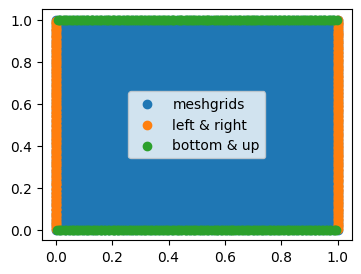

The trained model has been loaded !!!!


In [1]:
import numpy as np
import torch 
import torch.nn as nn
import h5py
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
tag = 'PhysicsDriven'; task = 'task_maximize';
n_sample = 50;
#
res_coe, res_sol = 32, 64
mu = [10., 2.] # [phase=1, phase=0]
######################################
# Generate boundary data
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
x_in = pointGen.inner_point(res_sol, method='mesh')
#
N_bd_each_edge = 150
x_bd = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
x_lr = x_bd[0:2*N_bd_each_edge]
x_bu = x_bd[2*N_bd_each_edge:]
print('The shape of x_in:', x_in.shape, 'x_left&right:', x_lr.shape, 'x_bottom&up:', x_bu.shape)
#
plt.figure(figsize=(4,3))
plt.scatter(x_in[:,0], x_in[:,1], label='meshgrids', linewidth=1.)
plt.scatter(x_lr[:,0], x_lr[:,1], label='left & right')
plt.scatter(x_bu[:,0], x_bu[:,1], label='bottom & up')
plt.legend()
plt.show()

# #####################################
# # Load the trained model
# #####################################
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_list, activation, dtype):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_list, activation, dtype) 
        
    def forward(self, feat):
        '''
        Input:
            feat: size(batch_size, a_size)
        Return:
            output: size(?, beta_size) -> size(? beta_size)
        '''
        beta = self.encoder(feat)
        beta = torch.tanh(beta)
        return beta
        
################ Load 
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_{tag}/', name=f'model_dgno_final')
#
print('The trained model has been loaded !!!!')

## (2) Define the objective function

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
class mollifer_x(object):

    def __inint__(self):
        super(mollifer_x, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        xx, yy = x[...,0], x[...,1]
        u = u * torch.sin(np.pi * xx) + torch.sin(np.pi/2 * xx)
        return u.unsqueeze(-1)
#
class mollifer_y(object):

    def __inint__(self):
        super(mollifer_y, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        xx, yy = x[...,0], x[...,1]
        u = u * torch.sin(np.pi * yy) + torch.sin(np.pi/2 * yy)
        return u.unsqueeze(-1)
#
def a_sample(a_prob, samples=20):
    '''Reparameterization trick for Multivariate Bernoulli: https://davidstutz.de/bernoulli-variational-auto-encoder-in-torch/
    a_prob: size(n_batch, mesh_size, 1)
    '''
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*(mu[0]-mu[1]) + mu[1]
    
    return a

###############################
class LossClass(object):

    def __init__(self, model_beta, device, dtype):
        super(LossClass, self).__init__()
        ''' '''
        self.device = device
        self.dtype = dtype
        #
        self.mollifer_x = mollifer_x()
        self.mollifer_y = mollifer_y()
        #
        self.model_beta = model_beta
        self.model_a = model_trained['a']
        self.model_ux = model_trained['ux']
        self.model_uy = model_trained['uy']
        self.model_sx1 = model_trained['sx1']
        self.model_sx2 = model_trained['sx2']
        self.model_sy1 = model_trained['sy1']
        self.model_sy2 = model_trained['sy2']
        #######################
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)
        self.x_mesh = x_in.unsqueeze(0).to(device)
        self.dx, self.dy = 1/(res_sol-1), 1/(res_sol-1)
        #
        self.n_sample = n_sample
        self.ones = torch.ones((1,1)).to(device)
        
    def Loss_pde(self, nc=100):
        ''' The PDE loss'''
        return torch.tensor(0.)

    def Loss_target(self):
        '''Add design objective'''
        n_batch = self.n_sample
        beta = self.model_beta(self.ones).view(n_batch, 128)
        x = Variable(self.x_mesh, requires_grad=True)
        x = x.repeat((n_batch, 1, 1))
        #
        a_prop = nn.Sigmoid()(model_trained['a'](x, beta))
        a_pred = a_sample(a_prop)
        ############################ The conductivity in the x-direction
        ux_pred = self.model_ux(x, beta)
        ux_pred = self.mollifer_x(ux_pred, x)
        dux_pred = grad(inputs=x, outputs=ux_pred, grad_outputs=torch.ones_like(ux_pred), create_graph=True)[0]
        duxx_pred = dux_pred[...,0]
        #
        flux = duxx_pred * a_pred
        cdx = torch.mean(flux, dim=-1) #/ torch.mean(duxx_pred, dim=-1)
        ############################ The conductivity in the y-direction
        uy_pred = self.model_uy(x, beta)
        uy_pred = self.mollifer_y(uy_pred, x)
        duy_pred = grad(inputs=x, outputs=uy_pred, grad_outputs=torch.ones_like(uy_pred), create_graph=True)[0]
        duyy_pred = duy_pred[...,1]
        #
        flux = duyy_pred * a_pred
        cdy = torch.mean(flux, dim=-1) #/ torch.mean(duyy_pred, dim=-1)
        #
        obj = (cdy/cdx)

        return torch.mean(obj)

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class BetaModel(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(BetaModel, self).__init__()
        self.fc = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, ones):
        beta = self.fc(ones)
        beta = torch.tanh(beta)
        
        return beta
#
layers_beta, act_beta = [1, 2, 2, 128*n_sample], 'SiLU'
model_beta = BetaModel(layers_beta, act_beta, dtype=dtype).to(device)
#
print('The design objective has been defined !!!')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])
The design objective has been defined !!!


## (3) Solve the optimization problem

In [3]:
import time
from tqdm import trange
################# Training setups
epochs = 500
lr = 1e-2
optimizer = torch.optim.AdamW(params=model_beta.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
###############
loss_total_list, loss_pde_list, loss_target_list = [], [], []
t0 = time.time()
#
for epoch in trange(epochs):
    #
    lossClass = LossClass(model_beta, device, dtype)
    loss_pde = lossClass.Loss_pde() 
    loss_target = lossClass.Loss_target() 
    loss_total = 1.*loss_target
    #
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()
    scheduler.step()  # Adjust learning rate
    #
    loss_pde_list.append(loss_pde.item())
    loss_target_list.append(loss_target.item())
    loss_total_list.append(loss_total.item())
    #
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss_total is:{loss_total.item()}, The loss_target is:{loss_target.item()}')
print('The consuming time is:', time.time()-t0)
################### save the trained model
torch.save(model_beta, f'saved_models/DGNO_{tag}/{task}/'+f'model_dgno_inverse.pth')

 20%|██████                        | 101/500 [00:19<01:14,  5.34it/s]

Epoch:99, The loss_total is:0.0972030982375145, The loss_target is:0.0972030982375145


 40%|████████████                  | 201/500 [00:37<00:56,  5.34it/s]

Epoch:199, The loss_total is:0.07965321093797684, The loss_target is:0.07965321093797684


 60%|██████████████████            | 301/500 [00:56<00:37,  5.33it/s]

Epoch:299, The loss_total is:0.07519948482513428, The loss_target is:0.07519948482513428


 80%|████████████████████████      | 401/500 [01:15<00:18,  5.34it/s]

Epoch:399, The loss_total is:0.07248753309249878, The loss_target is:0.07248753309249878


100%|██████████████████████████████| 500/500 [01:33<00:00,  5.33it/s]

Epoch:499, The loss_total is:0.07164262980222702, The loss_target is:0.07164262980222702
The consuming time is: 93.8806848526001


## (4) Make prediction with the optimized solution

The shape of a_pred torch.Size([50, 32, 32])
Pred. cdx: tensor([5.6895, 5.7037, 5.0661, 4.5046, 5.4899, 5.3288, 5.4601, 5.6387, 4.9133,
        5.6260, 5.2235, 5.6138, 5.5976, 5.5476, 5.3213, 5.6280, 5.1481, 4.8133,
        4.9798, 5.3981, 5.0838, 5.3835, 5.7320, 4.9046, 5.3374, 4.9575, 5.8959,
        5.3596, 5.4971, 4.7718, 5.5552, 4.9636, 4.8532, 5.1252, 5.1362, 5.3416,
        4.4289, 5.2255, 5.0527, 4.7633, 5.5130, 5.4262, 5.7714, 5.5918, 5.2458,
        5.8117, 5.4065, 5.2296, 5.5323, 5.1164])
Pred. cdy: tensor([3.4878, 3.7609, 2.6956, 3.0145, 3.8460, 2.8896, 3.7055, 3.5432, 3.7073,
        3.4291, 3.2451, 3.3255, 3.0399, 3.3700, 3.6860, 3.2196, 2.4043, 3.3784,
        3.3719, 2.7659, 4.0197, 3.1339, 4.6596, 3.1363, 3.2265, 3.1934, 3.5139,
        2.8749, 3.4544, 3.7054, 3.9654, 3.2222, 3.4650, 3.1889, 3.5707, 4.1942,
        3.4568, 3.4321, 2.9873, 2.7734, 3.5299, 3.5927, 3.4325, 2.9432, 3.4269,
        3.8695, 3.8140, 2.9668, 3.0501, 3.4495])
***********************************

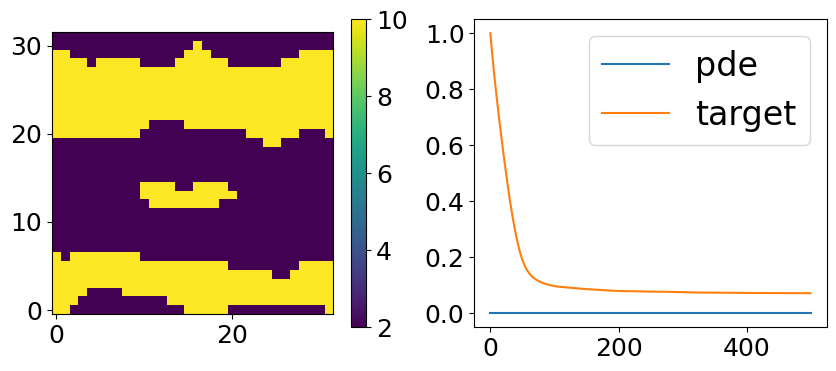

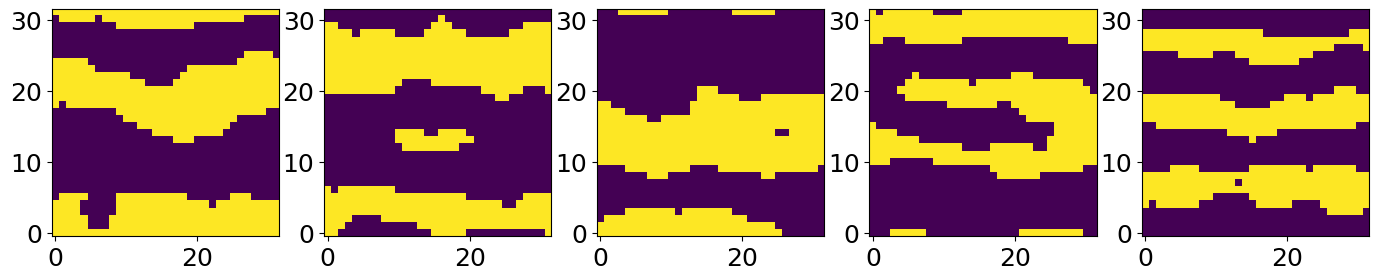

In [4]:
####################################### Load the trained model
def a_sample(a_prob, samples=10):
    '''Reparameterization trick for Multivariate Bernoulli: https://davidstutz.de/bernoulli-variational-auto-encoder-in-torch/
    a_prob: size(n_batch, mesh_size, 1)
    '''
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*(mu[0]-mu[1]) + mu[1]
    
    return a
#
class Get_High_Resolution_a(object):

    def __init__(self, res_coe):
        super(Get_High_Resolution_a, self).__init__()
        self.res = res_coe
        self.delta = 1./(res_coe-1)

    def __call__(self, x_mesh, a):
        ''' 
        Input:
            x_mesh: size(n_batch, n_mesh, 2)
            a: size(n_batch, nx*ny)
        Result:
            a_new: size(n_batch, n_mesh)
        '''
        x_loc = torch.floor(x_mesh[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x_mesh[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        a_new = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return a_new
#####################################
def Pred(x, n_sample=n_sample):
    ''' '''
    batch_size = n_sample
    dx, dy = 1./(res_sol-1), 1./(res_sol-1)
    #
    x = x.repeat((batch_size, 1, 1))
    beta = model_beta(torch.ones((1,1)).to(device)).view(batch_size, 128)
    a_prop = nn.Sigmoid()(model_trained['a'](x, beta)).detach().cpu()
    a_pred = a_sample(a_prop).reshape(-1, res_sol, res_sol)
    ############################ The conductivity in the x-direction
    flux = model_trained['sx1'](x, beta).detach().cpu()
    #
    cdx = torch.mean(flux.reshape(batch_size,-1), dim=-1) 
    ############################ The conductivity in the y-direction
    flux = model_trained['sy2'](x, beta).detach().cpu()
    #
    cdy = torch.mean(flux.reshape(batch_size,-1), dim=-1) 

    return a_pred, cdx, cdy, beta
#############################################
a_pred_highRes, cdx_pred, cdy_pred, beta = Pred(x_in.unsqueeze(0).to(device))
a_pred_highRes[a_pred_highRes>5] = 10; a_pred_highRes[a_pred_highRes<5]=2.;
############################################## Obtain the prediction of structures (res=same)
x_coe = pointGen.inner_point(res_coe, method='mesh')
x_coe = x_coe.unsqueeze(0).repeat((beta.shape[0], 1, 1))
a_prop = nn.Sigmoid()(model_trained['a'](x_coe.to(device), beta)).detach().cpu()
a_pred = a_sample(a_prop).reshape(-1, res_coe, res_coe)
a_pred[a_pred>5] = 10; a_pred[a_pred<5]=2.;
############################################# save the data
with h5py.File(f'saved_models/DGNO_{tag}/{task}/designed_img.h5', 'w') as data:
    data.create_dataset('coe', data=a_pred)
    data.create_dataset('coe_highRes', data=a_pred_highRes)
    data.create_dataset('cdx_pred', data=cdx_pred)
    data.create_dataset('cdy_pred', data=cdy_pred)
    
#
print('The shape of a_pred', a_pred.shape)
print('Pred. cdx:', cdx_pred)
print('Pred. cdy:', cdy_pred)
print('*************************************')
inx = 1
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cntr = axes[0].imshow(a_pred[inx], origin='lower')
plt.colorbar(cntr)
axes[1].plot(loss_pde_list, label='pde')
axes[1].plot(loss_target_list, label='target')
plt.legend()
plt.show()
#
fig, axes = plt.subplots(1,5, figsize=(17, 3))
for i in range(5):
    axes[i].imshow(a_pred[i], origin='lower')
plt.show()